# Denoising Autoencoder

In [17]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
np.random.seed(1234)

# Dataset

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
image_size = x_train.shape[1]

In [5]:
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

add noise(mean = 0.5, std = 0.5)

In [6]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

fix [0, 1]

In [9]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Hyperparameter

In [10]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16

# Model

## Autoencoder

### Encoder

In [14]:
inputs = Input(shape = input_shape, name='encoder_input')
x = inputs
x = Conv2D(filters=32, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
x = Conv2D(filters=64, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

shape = K.int_shape(x) # (7, 7, 64)

# Latent Vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [16]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


### Decoder

In [19]:
latent_inputs = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=64, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(filters=32, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid',name='decoder_output')(x)

In [20]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [21]:
AE = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
AE.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [22]:
AE.compile(loss='mse', optimizer='adam')

In [23]:
AE.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=10, batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0365 - val_loss: 0.0206
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0195 - val_loss: 0.0180
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0179 - val_loss: 0.0176
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0171 - val_loss: 0.0167
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0155 - val_loss: 0.0157
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.015

In [24]:
x_decoded = AE.predict(x_test_noisy)

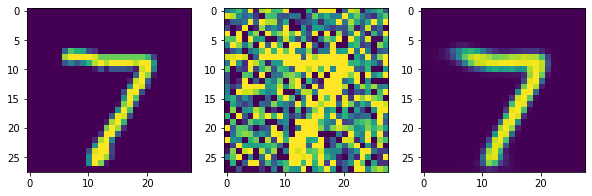

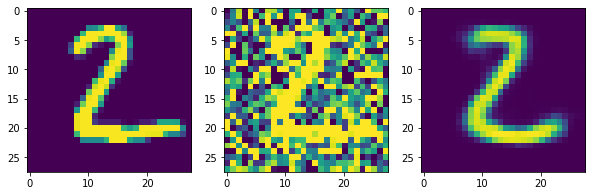

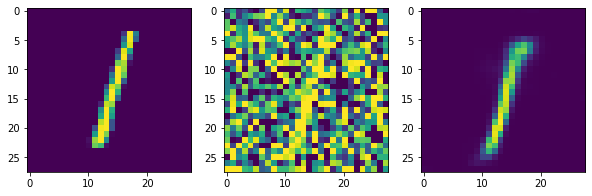

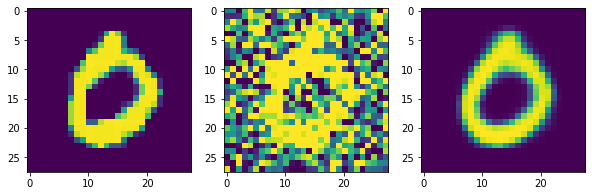

In [39]:
for i in range(0,4):
    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.imshow(x_test[i])

    plt.subplot(1,3,2)
    plt.imshow(x_test_noisy[i])

    plt.subplot(1,3,3)
    plt.imshow(x_decoded[i])

    plt.show()